In [15]:
import xarray as xr
import fsspec
import os
from vcm.select import RegionOfInterest

kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
kg_m2_to_mm  = 1000. / 997.0

import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
import fv3viz
import cftime
import datetime
import pandas as pd
#import proplot

import matplotlib.pyplot as plt
import os
from datetime import timedelta
#import seaborn as sns
import vcm

plt.rcParams.update({'font.sans-serif':'TeX Gyre Heros'})


slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()

figsize=(12,4)
col_wrap = 2
rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}

tick_loc = np.array([-60, -30, -15, 0, 15, 30, 60])
tick_loc_sin = np.sin(tick_loc * np.pi/180)

In [2]:
experiments = {
    "Baseline": "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed",
    "NN ensemble": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble",
    #"ML seed 0": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-0",
    #"ML seed 1": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-1",
    #"ML seed 2": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-2",
    #"ML seed 3": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-3"

}

In [3]:
diags_vars =  ['column_int_dqu_zonal_mean_bias',
 'column_int_dqu_zonal_mean_value',
 'column_int_dqv_zonal_mean_bias',
 'column_int_dqv_zonal_mean_value',
 'column_integrated_dq1_zonal_mean_bias',
 'column_integrated_dq1_zonal_mean_value',
 'column_integrated_dq2_zonal_mean_bias',
 'column_integrated_dq2_zonal_mean_value',
 'column_integrated_nq1_zonal_mean_bias',
 'column_integrated_nq1_zonal_mean_value',
 'column_integrated_nq2_zonal_mean_bias',
 'column_integrated_nq2_zonal_mean_value',
 'column_integrated_pq1_zonal_mean_bias',
 'column_integrated_pq1_zonal_mean_value',
 'column_integrated_pq2_zonal_mean_bias',
 'column_integrated_pq2_zonal_mean_value',
 'column_integrated_q1_zonal_mean_bias',
 'column_integrated_q1_zonal_mean_value',
 'column_integrated_q2_zonal_mean_bias',
 'column_integrated_q2_zonal_mean_value',
 'dlwrfsfc_zonal_mean_bias',
 'dlwrfsfc_zonal_mean_value',
 'dswrfsfc_zonal_mean_bias',
 'dswrfsfc_zonal_mean_value',
 'h500_zonal_mean_bias',
 'h500_zonal_mean_value',
 'iw_zonal_mean_bias',
 'iw_zonal_mean_value',
 'lhtflsfc_zonal_mean_bias',
 'lhtflsfc_zonal_mean_value',
 'maxwind10m_zonal_mean_value',
 'pratesfc_zonal_mean_bias',
 'pratesfc_zonal_mean_value',
 'pressfc_zonal_mean_bias',
 'pressfc_zonal_mean_value',
 'prmsl_zonal_mean_value',
 'pwat_zonal_mean_bias',
 'pwat_zonal_mean_value',
 'q1000_zonal_mean_bias',
 'q1000_zonal_mean_value',
 'q500_zonal_mean_bias',
 'q500_zonal_mean_value',
 'rh1000_zonal_mean_value',
 'rh500_zonal_mean_value',
 'rh850_zonal_mean_value',
 'shtflsfc_zonal_mean_bias',
 'shtflsfc_zonal_mean_value',
 'soilm_zonal_mean_value',
 'tmp200_zonal_mean_bias',
 'tmp200_zonal_mean_value',
 'tmp500_300_zonal_mean_value',
 'tmp850_zonal_mean_bias',
 'tmp850_zonal_mean_value',
 'tmplowest_zonal_mean_bias',
 'tmplowest_zonal_mean_value',
 'tmpsfc_zonal_mean_bias',
 'tmpsfc_zonal_mean_value',
 'total_precip_to_surface_zonal_mean_bias',
 'total_precip_to_surface_zonal_mean_value',
 'ugrd10m_zonal_mean_bias',
 'ugrd10m_zonal_mean_value',
 'ugrd200_zonal_mean_bias',
 'ugrd200_zonal_mean_value',
 'ugrd850_zonal_mean_bias',
 'ugrd850_zonal_mean_value',
 'ulwrftoa_zonal_mean_bias',
 'ulwrftoa_zonal_mean_value',
 'uswrftoa_zonal_mean_bias',
 'uswrftoa_zonal_mean_value',
 'vgrd10m_zonal_mean_bias',
 'vgrd10m_zonal_mean_value',
 'vgrd850_zonal_mean_value',
 'vil_zonal_mean_bias',
 'vil_zonal_mean_value',
 'w500_zonal_mean_bias',
 'w500_zonal_mean_value',
 'water_vapor_path_zonal_mean_bias',
 'water_vapor_path_zonal_mean_value']

In [4]:
diags, labels = [], []

for experiment, prog_run in experiments.items():
    with fsspec.open(os.path.join(prog_run, "fv3gfs_run_diagnostics", "diags.nc")) as f:
        diags.append(xr.open_dataset(f)[diags_vars].load())
    labels.append(experiment)
ds_diags = xr.concat(diags, dim=pd.Index(labels, name="experiment"))

In [5]:
exps = ["Baseline", "NN ensemble"]
sin_lat= np.sin( ds_diags.latitude.values * (np.pi/180))
ds_diags_transformed_lat = ds_diags \
    [["tmp200_zonal_mean_bias", "pratesfc_zonal_mean_bias", "pwat_zonal_mean_bias", "w500_zonal_mean_bias", "vgrd850_zonal_mean_value"]] \
    .assign_coords(latitude=sin_lat) \
    .load()

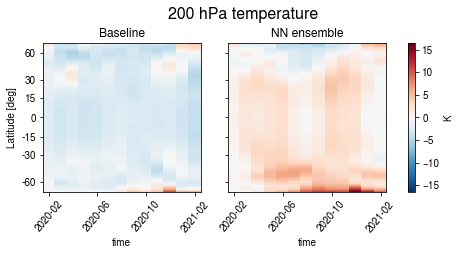

In [17]:
f = (
        (ds_diags_transformed_lat["tmp200_zonal_mean_bias"] ).sel(experiment=exps)
).resample(time="1M").mean() \
.plot(col="experiment", x="time",)# rasterized=True)

for i, exp in enumerate(exps):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    ax = f.axes[0][0].set_ylabel("Latitude [deg]")    

    

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.

f.cbar.ax.set_ylabel("K")
plt.suptitle("200 hPa temperature", y=1.05, fontsize=16)

plt.savefig("figures/pdf/prognostic_hovmoller_t200_bias.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_hovmoller_t200_bias.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_hovmoller_t200_bias.eps", format="eps", bbox_inches='tight')

Our ML-correcte a warm bias develop in 200 hPa air temperature over the year,  the baseline model's cold bias in this field. 


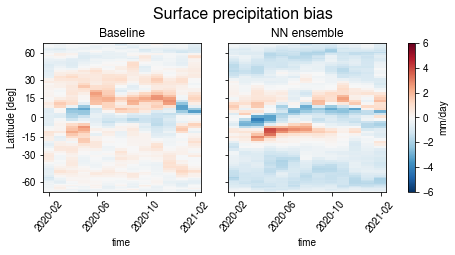

In [18]:
f = (
        (ds_diags_transformed_lat["pratesfc_zonal_mean_bias"] * kg_m2s_to_mm_day).sel(experiment=exps)
).resample(time="1M").mean() \
.plot(col="experiment", x="time", vmax=6)

for i, exp in enumerate(exps):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    ax = f.axes[0][0].set_ylabel("Latitude [deg]")    

f.cbar.ax.set_ylabel("mm/day")
plt.suptitle("Surface precipitation bias", y=1.05, fontsize=16)
plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.


plt.savefig("figures/pdf/prognostic_hovmoller_precip_bias.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_hovmoller_precip_bias.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_hovmoller_precip_bias.eps", format="eps", bbox_inches='tight')

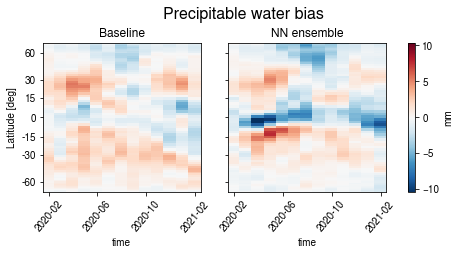

In [19]:
f = (
        (ds_diags_transformed_lat["pwat_zonal_mean_bias"] * kg_m2_to_mm).sel(experiment=exps)
).resample(time="1M").mean() \
.plot(col="experiment", x="time")

for i, exp in enumerate(exps):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)
ax = f.axes[0][0].set_ylabel("Latitude [deg]")    
f.cbar.ax.set_ylabel("mm")
plt.suptitle("Precipitable water bias", y=1.05, fontsize=16)

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.

plt.savefig("figures/pdf/prognostic_hovmoller_pwat_bias.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_hovmoller_pwat_bias.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_hovmoller_pwat_bias.eps", format="eps", bbox_inches='tight')

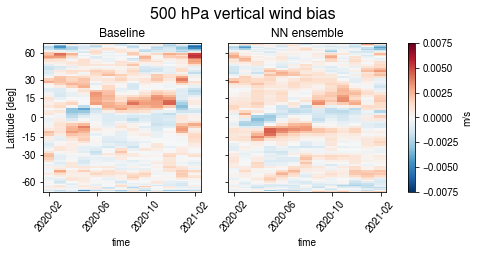

In [21]:
exps = ["Baseline", "NN ensemble"]
f = (
        (ds_diags_transformed_lat["w500_zonal_mean_bias"] ).sel(experiment=exps)
).resample(time='1M').mean() \
.plot(col="experiment", x="time", vmax=0.0075)

for i, exp in enumerate(exps):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)
f.axes[0][0].set_ylabel("Latitude [deg]")    
f.cbar.ax.set_ylabel("m/s")
plt.suptitle("500 hPa vertical wind bias", y=1.05, fontsize=16)
plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.


plt.savefig("figures/pdf/prognostic_hovmoller_w500_bias.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_hovmoller_w500_bias.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_hovmoller_w500_bias.eps", format="eps", bbox_inches='tight')

In [22]:
vwind_verif = catalog["2020_1yr_pire_vwinds"].read()
vwind_verif_zonal_mean = vcm.zonal_average_approximate(
    grid.lat,
    vwind_verif.rename({"grid_xt": "x", "grid_yt": "y"}),
    lat_name="latitude"
).sel(time=ds_diags.time[:-1])

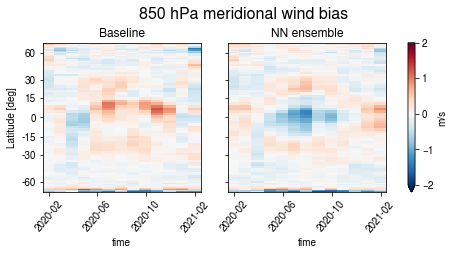

In [23]:
f = (
        (ds_diags["vgrd850_zonal_mean_value"] - vwind_verif_zonal_mean["VGRD850"] ).sel(experiment=["Baseline", "NN ensemble"])
).assign_coords(latitude=sin_lat) \
.resample(time="1M").mean() \
.plot(col="experiment", x="time", vmax=2)

for i, exp in enumerate(["Baseline", "NN ensemble"]):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)
ax = f.axes[0][0].set_ylabel("Latitude [deg]")    
f.cbar.ax.set_ylabel("m/s")
plt.suptitle("850 hPa meridional wind bias", y=1.05, fontsize=16)

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.


plt.savefig("figures/pdf/prognostic_hovmoller_v850_bias.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_hovmoller_v850_bias.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_hovmoller_v850_bias.eps", format="eps", bbox_inches='tight')

([<matplotlib.axis.YTick at 0x7ff5043fe310>,
 [])

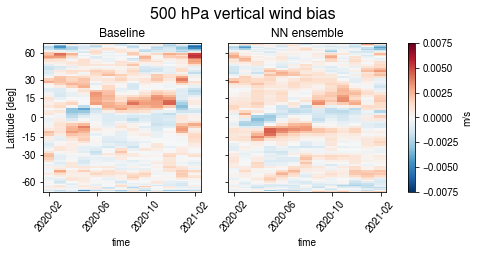

In [24]:
exps = ["Baseline", "NN ensemble"]

f = (
        (ds_diags_transformed_lat["w500_zonal_mean_bias"] ).sel(experiment=exps)
).resample(time='1M').mean() \
.plot(  col="experiment", x="time", vmax=0.0075)


for i, exp in enumerate(exps):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)
f.axes[0][0].set_ylabel("Latitude [deg]")    
f.cbar.ax.set_ylabel("m/s")
plt.suptitle("500 hPa vertical wind bias", y=1.05, fontsize=16, fontname='TeX Gyre Heros')

plt.yticks([])  # Set label locations.


plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.
